# Generate Train / Validation / Test Sets

In this notebook, the purpose is to create a dataset to train `masked or not masked face` classifier model. The data generation consists of three main steps;
1. Sampled images from [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) dataset
2. Added artificial masks to half of the sampled images and create training dataset as `masked` and `not masked`
3. Generated validation and test set from real masked and not masked raw face images, to measure the performance of the model. Note that we don't use artificial masks on validation and test set to get more realistic evaluation. The raw images are manually labelled and more information about this labelling can be found in `test_validation_metadata.csv` file.

The details of each step is covered in detail in the following sections.

## Import Libraries

In [71]:
import os
import sys
import random
from pathlib import Path
from shutil import copyfile
import glob
from tqdm import tqdm

# Image Processing
from PIL import Image, ImageFile
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Classification Model
import tensorflow as tf

# Data Manipulation
import pandas as pd

# Download Data
import urllib.request
from google_drive_downloader import GoogleDriveDownloader as gdd

ROOT_DIR = os.path.dirname(os.path.abspath(os.curdir))

# Add retinaface-tf2 submodule to PATH
RETINAFACE_DIR = os.path.join(ROOT_DIR, 'retinaface-tf2')
if RETINAFACE_DIR not in sys.path: # add retinaface-tf2 repo to PATH
    sys.path.append(RETINAFACE_DIR)

# Retinaface models
from modules.models import RetinaFaceModel
from modules.utils import pad_input_image, recover_pad_output, load_yaml

# Face recognition model to find facial landmarks
import face_recognition

## Set Global Variables and Paths

In [72]:
# Set seed to sample same set of images each time
random.seed(61)

# Sample 10 images per indentity (person)
N_IMAGES_PER_IDENTITY = 10

# We need nose bridge and chin to fit mask on a face
KEY_FACIAL_FEATURES = {'nose_bridge', 'chin'}
MODEL = 'cnn' # cnn or hog cnn is slower than hog but more accurate in terms of face detection

# Disable TF warnings (Disabling the warnings is not a good practice but we disable it to make this notebook prettier)
tf.get_logger().setLevel('ERROR')

RETINAFACE_CFG_PATH = Path(RETINAFACE_DIR) / 'configs' / 'retinaface_mbv2.yaml'
DATA_DIR = Path(ROOT_DIR) / 'data'
VGGFACE2_DIR = Path(ROOT_DIR) / 'vggface2'

# Raw images will be used for validation and test set. Note that VGGFace2 images will be used for training. 
RAW_IMAGES_DIR = DATA_DIR / 'raw_images'

## Get Sample Face Data From VGGFace2 Dataset

To train our **masked or not masked** model, we used [VGGFace2 dataset](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/). This dataset provides us a homogenous face collection to better train our model. The faces in this dataset are from several  ethnicities and age groups. The photos are captured in the wild with different emotions.

Follow the steps below to download `VGGFace2 Dataset` and run this notebook.
1. Sign up/in to [VGGFace2 dataset](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/)
2. Download `Test Data_v1` from [here](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/data_infor.html). Note that we do not download `Train Data_v1` because `Test Data_v1` is more than enough to train our `masked or not masked model`.
3. Extract downloaded `Test Data_v1`, rename the folder as `vggface2` and move `vggface2` folder to the root directory of this repository.

In [5]:
# Find identity directories in test folder
identity_dirs = [x for x in VGGFACE2_DIR.iterdir() if x.is_dir()]

# Create a directory to save sampled images if not created
sampled_image_dir = os.path.join(ROOT_DIR, 'data', 'sampled_face_images')
os.makedirs(sampled_image_dir, exist_ok=True)

# Delete all images from sampled_face_images folder if already exists
images = glob.glob(os.path.join(sampled_image_dir, '*'))
for f in images:
    os.remove(f)
    
# Get N_IMAGES_PER_IDENTITY sample images from each identity and save it to sample_faces directory
for identity_dir in identity_dirs:
    indentity_face_images = glob.glob(os.path.join(identity_dir, "*.jpg"))
    sampled_image_dirs = random.sample(indentity_face_images, N_IMAGES_PER_IDENTITY)
    identity_name = os.path.basename(identity_dir)
    for src_dir in sampled_image_dirs:
        face_image_fname = os.path.basename(src_dir)
        dst_dir = os.path.join(sampled_image_dir, identity_name + '_' + face_image_fname)
        copyfile(src_dir, dst_dir)

## Prepare Train Set

The training dataset consist of two classes; **masked** and **not masked** persons. 

It was hard to find thousands of real masked face photos to train our model. Therefore, we decided to artifially put masks on people from `VGGFace2 dataset`. We used 13 different masks having different shape and color. To see the masks refer to `data/mask-templates` directory. For this strategy, we are influenced from [prajnasb/observasion repository](https://github.com/prajnasb/observations) repository. 

Our general strategy to create our train set is listed below
1. Detected the faces from each image under `data/sampled_face_images` directory. Note that in face detection we don't use `retinaface model` and we are using `face_recognition` library because we need facial landmarks to artificially place mask on a face. 
2. Cropped the detected faces from the images
3. Applied artificial masks onto half of the detected faces and labelled these faces as `masked`. Masked faces are saved under `data/train/masked` directory.
4. The remaining other half of the detected faces are labelled as `not masked` and saved it under `data/train/not_masked`

### Helper Functions to Artificially Place Mask on a  Face

In [2]:
def create_masked_face(image_path, mask_path):
    # Convert image into a format that face_recognition library understands
    face_image_np = face_recognition.load_image_file(image_path)
    
    # Recognize face boundaries from an image 
    face_locations = face_recognition.face_locations(face_image_np, model=MODEL)
    
    # Find facial landmarks from the recognized face to fit mask
    face_landmarks = face_recognition.face_landmarks(face_image_np, face_locations)
    has_key_face_landmarks = check_face_landmarks(face_landmarks)
    
    if has_key_face_landmarks:
        face_img = Image.fromarray(face_image_np)
        mask_img = Image.open(mask_path)
        face_mask_img = mask_face(face_img, mask_img, face_landmarks[0])
        cropped_face_mask_img = crop_image(face_mask_img, face_locations[0])
        return cropped_face_mask_img
    else:
        return None

def check_face_landmarks(face_landmarks):
    # Check whether there is a face_landmark
    if len(face_landmarks) > 0:
        # Check whether face_landmarks include all key facial features to fit mask
        if face_landmarks[0].keys() >= KEY_FACIAL_FEATURES:
            return True
        else:
            return False
    else:
        return False

def mask_face(face_img, mask_img, face_landmark):
    nose_bridge = face_landmark['nose_bridge']
    nose_point = nose_bridge[len(nose_bridge) * 1 // 4]
    nose_v = np.array(nose_point)

    chin = face_landmark['chin']
    chin_len = len(chin)
    chin_bottom_point = chin[chin_len // 2]
    chin_bottom_v = np.array(chin_bottom_point)
    chin_left_point = chin[chin_len // 8]
    chin_right_point = chin[chin_len * 7 // 8]

    # split mask and resize
    width = mask_img.width
    height = mask_img.height
    width_ratio = 1.2
    new_height = int(np.linalg.norm(nose_v - chin_bottom_v))

    # left
    mask_left_img = mask_img.crop((0, 0, width // 2, height))
    mask_left_width = get_distance_from_point_to_line(chin_left_point, nose_point, chin_bottom_point)
    mask_left_width = int(mask_left_width * width_ratio)
    mask_left_img = mask_left_img.resize((mask_left_width, new_height))

    # right
    mask_right_img = mask_img.crop((width // 2, 0, width, height))
    mask_right_width = get_distance_from_point_to_line(chin_right_point, nose_point, chin_bottom_point)
    mask_right_width = int(mask_right_width * width_ratio)
    mask_right_img = mask_right_img.resize((mask_right_width, new_height))

    # merge mask
    size = (mask_left_img.width + mask_right_img.width, new_height)
    mask_img = Image.new('RGBA', size)
    mask_img.paste(mask_left_img, (0, 0), mask_left_img)
    mask_img.paste(mask_right_img, (mask_left_img.width, 0), mask_right_img)

    # rotate mask
    angle = np.arctan2(chin_bottom_point[1] - nose_point[1], chin_bottom_point[0] - nose_point[0])
    rotated_mask_img = mask_img.rotate(angle, expand=True)

    # calculate mask location
    center_x = (nose_point[0] + chin_bottom_point[0]) // 2
    center_y = (nose_point[1] + chin_bottom_point[1]) // 2

    offset = mask_img.width // 2 - mask_left_img.width
    radian = angle * np.pi / 180
    box_x = center_x + int(offset * np.cos(radian)) - rotated_mask_img.width // 2
    box_y = center_y + int(offset * np.sin(radian)) - rotated_mask_img.height // 2

    # add mask
    face_img.paste(mask_img, (box_x, box_y), mask_img)
    return face_img

def get_distance_from_point_to_line(point, line_point1, line_point2):
    distance = np.abs((line_point2[1] - line_point1[1]) * point[0] +
                      (line_point1[0] - line_point2[0]) * point[1] +
                      (line_point2[0] - line_point1[0]) * line_point1[1] +
                      (line_point1[1] - line_point2[1]) * line_point1[0]) / \
               np.sqrt((line_point2[1] - line_point1[1]) * (line_point2[1] - line_point1[1]) +
                       (line_point1[0] - line_point2[0]) * (line_point1[0] - line_point2[0]))
    return int(distance)

def save(save_dir, fname, face_img):
    dest_path = os.path.join(save_dir, fname)
    face_img.save(dest_path)
    
def crop_image(img, face_location):
    top, right, bottom, left = face_location
    return img.crop((left, top, right, bottom))

### Write Artificially Masked Faces into Disk

In this part, we get half of the images from `data/sampled_face_images`, crop the faces and apply artificial mask on faces. The masked faces will be saved under `data/train/masked` directory.

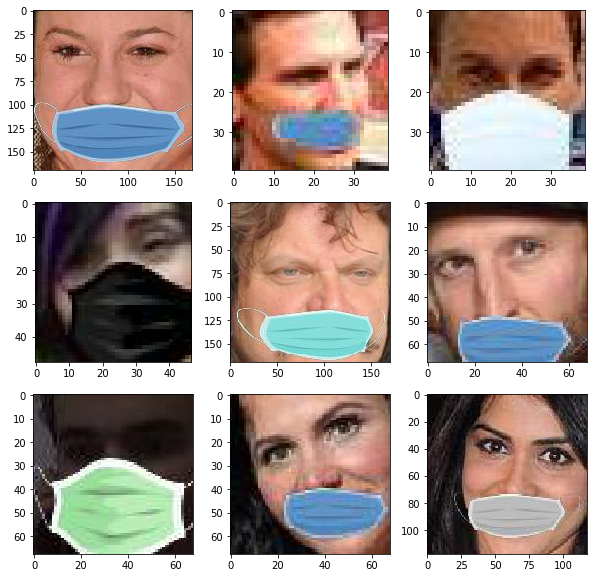

In [128]:
# Get available masks in mask-templates dir
available_masks = glob.glob(os.path.join(ROOT_DIR, 'data', 'mask-templates', "*.png"))
available_sample_face_imgs = glob.glob(os.path.join(ROOT_DIR, 'data', 'sampled_face_images', "*.jpg"))
random.shuffle(available_sample_face_imgs)

# Half of the images will be masked and the other half will be not masked
target_n_masked_face_imgs = len(available_sample_face_imgs) / 2
n_masked_images = 0

# Create a directory to save masked / not masked images
masked_img_dir = os.path.join(ROOT_DIR, 'data', 'train', 'masked')
not_masked_img_dir = os.path.join(ROOT_DIR, 'data', 'train', 'not_masked')
os.makedirs(os.path.join(ROOT_DIR, 'data', 'train'), exist_ok=True)
os.makedirs(masked_img_dir, exist_ok=True)
os.makedirs(not_masked_img_dir, exist_ok=True)

pbar = tqdm(total=target_n_masked_face_imgs)

# Add artificial mask to the detected faces until we reach half of the images in sampled_face_images directory
while n_masked_images < target_n_masked_face_imgs:
    image_path = available_sample_face_imgs.pop()
    fname  = os.path.basename(image_path)
    
    random_mask_path = random.choice(available_masks)
    try:
        masked_face = create_masked_face(image_path, random_mask_path)
    except:
        print('{} file is passed'.format(fname))
    if masked_face is not None:
        save(masked_img_dir, fname, masked_face)
        n_masked_images += 1
        pbar.update(1)
pbar.close()

# Plot some examples
ex_artif_masked_face_dirs = random.sample(glob.glob(os.path.join(masked_img_dir, '*.jpg')), 9)
fig = plt.figure(figsize=(10, 10))
for idx, artif_masked_face_dir in enumerate(ex_artif_masked_face_dirs):
    pil_im = Image.open(artif_masked_face_dir)
    im_array = np.asarray(pil_im)
    fig.add_subplot(3, 3, idx + 1)
    plt.imshow(im_array)
plt.show()

### Write Not Masked Faces into Disk

In this part, the faces from the remaining images of `data/sampled_face_images` directory are detected and saved under `data/train/not_masked`.

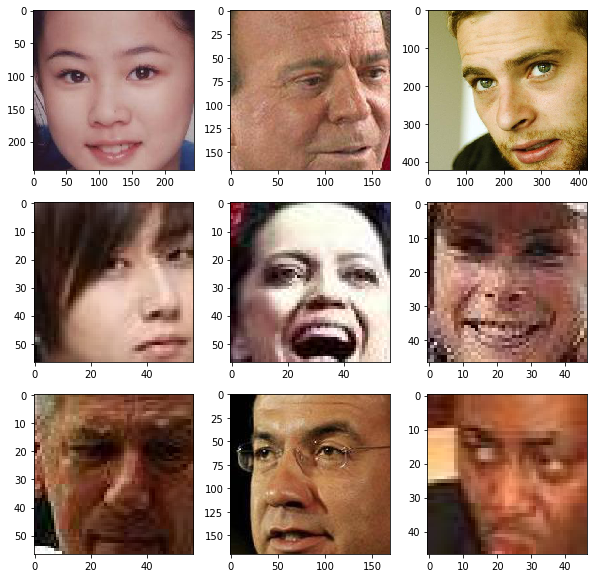

In [133]:
for remaining_img_path in tqdm(available_sample_face_imgs):
    # Convert image into format that face_recognition library understands 
    face_image_np = face_recognition.load_image_file(remaining_img_path)
    
    # Recognize face boundaries from an image 
    face_locations = face_recognition.face_locations(face_image_np, model=MODEL)

    img = Image.open(remaining_img_path)
    if len(face_locations) > 0:
        cropped_img = crop_image(img, face_locations[0])
        fname = os.path.basename(remaining_img_path)
        save(not_masked_img_dir, fname, cropped_img)
        
# Plot some examples
ex_not_masked_face_dirs = random.sample(glob.glob(os.path.join(not_masked_img_dir, '*.jpg')), 9)
fig = plt.figure(figsize=(10, 10))
for idx, not_masked_face_dir in enumerate(ex_not_masked_face_dirs):
    pil_im = Image.open(not_masked_face_dir)
    im_array = np.asarray(pil_im)
    fig.add_subplot(3, 3, idx + 1)
    plt.imshow(im_array)
plt.show()

## Prepare Validation and Test Set

Download the real masked images and not masked images from the urls to prepare our validation and test set.

**Masked face** URLs are located in `data/urls/masked/mask_image_urls.txt` and  **not masked face** URLs are located in `data/urls/masked/not_masked_image_urls.txt`

### Download Raw Images To Generate Validation and Test Set

Download all raw images to data/raw_images path. We will detect faces from these images and crop detected faces to generate our `validation` and `test` set.

In [106]:
# Read metadata to get raw image URLs and Raw image directories to save the downloaded images
df_test_validation_metadata = pd.read_csv(DATA_DIR / 'test_validation_metadata.csv', index_col=None)
df_test_validation_metadata

,class,x,y,w,h,image_urls,raw_img_dir,cropped_img_dir
0,masked,549,319,253,301,https://images.unsplash.com/photo-158009468719...,data/raw_images/0.jpg,data/validation/masked/0.jpg
1,masked,171,164,170,189,https://images.unsplash.com/photo-153000644495...,data/raw_images/1.jpg,data/test/masked/1.jpg
2,masked,253,94,90,110,https://images.unsplash.com/photo-158430983231...,data/raw_images/2.jpg,data/validation/masked/2.jpg
3,masked,171,255,129,182,https://images.unsplash.com/photo-151247906453...,data/raw_images/3.jpg,data/test/masked/3.jpg
4,masked,68,92,118,135,https://images.unsplash.com/photo-158452176459...,data/raw_images/4.jpg,data/validation/masked/4.jpg
...,...,...,...,...,...,...,...,...
519,not_masked,241,99,29,52,https://images.unsplash.com/photo-1551434678-e...,data/raw_images/271.jpg,data/test/not_masked/519.jpg
520,not_masked,337,55,58,94,https://images.unsplash.com/photo-1551434678-e...,data/raw_images/271.jpg,data/validation/not_masked/520.jpg
521,not_masked,303,116,24,32,https://images.unsplash.com/photo-1556761175-b...,data/raw_images/272.jpg,data/test/not_masked/521.jpg
522,not_masked,403,144,31,44,https://images.unsplash.com/photo-1556761175-b...,data/raw_images/272.jpg,data/validation/not_masked/522.jpg


In [91]:
opener=urllib.request.build_opener()
# the opener is needed to avoid 403 from pexels
opener.addheaders=[('User-Agent', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
urllib.request.install_opener(opener)

# Get raw image URLs
image_urls = df_test_validation_metadata['image_urls'].tolist()

# Get raw image directories
raw_img_dirs = df_test_validation_metadata['raw_img_dir'].tolist()

# Create a raw image folder if does not exist
os.makedirs(os.path.join(ROOT_DIR, os.path.dirname(raw_img_dirs[0])), exist_ok=True)

# Iterate over raw image URLs and download raw images to the specified folder
for idx, img_url in enumerate(image_urls):
    try:
        urllib.request.urlretrieve(img_url, os.path.join(ROOT_DIR, raw_img_dirs[idx]))
    except:
        print('skipping {}'.format('img_url'))
print('All raw images are downloaded to {}'.format(os.path.dirname(raw_img_dirs[0])))

All raw images are downloaded to data/raw_images


### Create Validation and Test Set from Downloaded Raw Images

By using raw images, masked or not masked faces are cropped. Note that we manually labeled the faces in raw images and the coordinates of the faces can be found in `test_validation_metadata.csv` file. 

The column descriptions of the labelled face coordinates;
- `x`: Left bottom corner x value
- `y`: Left bottom corner of y value
- `h`: Height of the labelled face
- `w`: Width of the labelled face

Validation set images can be found in `data/validation` and test set in `data/test` directories.

In [113]:
# Find all cropped image directories 
cropped_img_dirs = df_test_validation_metadata['cropped_img_dir'].apply(lambda x: os.path.dirname(x)).unique().tolist()

# Create directories if cropped directory does not exist 
for cropped_img_dir in cropped_img_dirs:
    os.makedirs(os.path.join(ROOT_DIR, cropped_img_dir), exist_ok=True)

for idx, row in df_test_validation_metadata.iterrows():
    img_raw_path = row['raw_img_dir']
    img = Image.open(os.path.join(ROOT_DIR, img_raw_path))
    img = img.crop((row['x'], row['y'], row['x'] + row['w'], row['y'] + row['h']))
    try:
        img.save(os.path.join(ROOT_DIR, row['cropped_img_dir']))
    except:
        print('skipping {} img'.format(row['image_urls']))

skipping https://cdn.pixabay.com/photo/2020/03/27/23/49/doctor-4975298_960_720.png img
